In [298]:
import pandas as pd
import numpy as np

In [299]:
data = pd.read_csv('Fish Data - A2.csv')
data.head

<bound method NDFrame.head of       Height   Width  Weight
0    11.5200  4.0200   242.0
1    12.4800  4.3056   290.0
2    12.3778  4.6961   340.0
3    12.7300  4.4555   363.0
4    12.4440  5.1340   430.0
..       ...     ...     ...
154   2.0904  1.3936    12.2
155   2.4300  1.2690    13.4
156   2.2770  1.2558    12.2
157   2.8728  2.0672    19.7
158   2.9322  1.8792    19.9

[159 rows x 3 columns]>

### Visualize the data

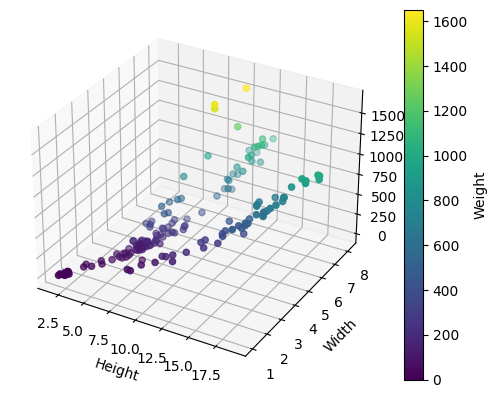

In [300]:
import matplotlib.pyplot as plt

x = data['Height']
y = data['Width']
z = data['Weight']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis')
ax.set_xlabel('Height')
ax.set_ylabel('Width')
ax.set_zlabel('Weight')
cbar = plt.colorbar(scatter)
cbar.set_label('Weight')

plt.show()

## Preprocessing

In [301]:
data['Height'].min(), data['Height'].max(), data['Width'].min(), data['Width'].max()

(1.7284, 18.957, 1.0476, 8.142)

In [302]:
mean_ht = data['Height'].mean()
mean_wd = data['Width'].mean()
std_ht = data['Height'].std()
std_wd = data['Width'].std()

mean_ht, mean_wd, std_ht, std_wd

(8.970993710691824, 4.417485534591195, 4.286207619968867, 1.6858038699921671)

In [303]:
data['Width'] = (data['Width'] - mean_wd) / std_wd
data['Height'] = (data['Height'] - mean_ht) / std_ht

data['Height'].min(), data['Height'].max(), data['Width'].min(), data['Width'].max()

(-1.68974402381946, 2.3297999478104403, -1.9989784070236196, 2.209340322267803)

In [304]:
data['Height'].fillna(data['Height'].mean(), inplace=True)
data['Weight'].fillna(data['Weight'].mean(), inplace=True)
data['Width'].fillna(data['Width'].mean(), inplace=True)

In [305]:
data = data.sample(frac=1,random_state=42)

train_size = int(0.8 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

In [306]:
len(train_data), len(test_data)

(127, 32)

## Find best degree for polynomial regression

In [307]:
MAX_DEGREE = 9
testing_mean_squared_errors = [0] * (MAX_DEGREE+1)
training_mean_squared_errors = [0] * (MAX_DEGREE+1)
weights = []

for degree in range(0, MAX_DEGREE+1):
    cnt = 0
    for height_pow in range(0, degree+1):
        for width_pow in range(0, degree+1):
            if height_pow + width_pow <= degree:
                cnt += 1
    poly_matrix = np.zeros((len(train_data), cnt))
    col = 0
    for height_pow in range(0, degree+1):
        for width_pow in range(0, degree+1):
            if height_pow + width_pow <= degree:
                poly_matrix[:, col] = np.power(train_data['Height'], height_pow) * np.power(train_data['Width'], width_pow)
                col += 1

    weight_vector = np.random.rand(cnt, 1)
    expected_vector = np.array(train_data['Weight']).reshape(-1, 1)

    ITERATIONS = int(1e4)
    LEARNING_RATE = 0.001

    for _ in range(ITERATIONS):
        predicted_vector = np.dot(poly_matrix, weight_vector)
        difference_vector = predicted_vector - expected_vector
        mean_squared_error = np.sum(np.square(difference_vector)) / len(train_data)
        gradient_vector = np.dot(poly_matrix.T, difference_vector) / len(train_data)
        weight_vector = weight_vector - LEARNING_RATE * gradient_vector

    predicted_vector = np.dot(poly_matrix, weight_vector)
    difference_vector = predicted_vector - np.array(train_data['Weight']).reshape(-1, 1)
    training_mean_squared_errors[degree] = np.sum(np.square(difference_vector)) / len(train_data)

    poly_matrix = np.zeros((len(test_data), cnt))
    col = 0
    for height_pow in range(0, degree+1):
        for width_pow in range(0, degree+1):
            if height_pow + width_pow <= degree:
                poly_matrix[:, col] = np.power(test_data['Height'], height_pow) * np.power(test_data['Width'], width_pow)
                col += 1
                
    weights.append(weight_vector)
    predicted_vector = np.dot(poly_matrix, weight_vector)
    difference_vector = predicted_vector - np.array(test_data['Weight']).reshape(-1, 1)
    testing_mean_squared_errors[degree] = np.sum(np.square(difference_vector)) / len(test_data)

C:\Users\krovi\AppData\Local\Temp\ipykernel_12740\3805116894.py:29: RuntimeWarning: overflow encountered in square
  mean_squared_error = np.sum(np.square(difference_vector)) / len(train_data)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Plotting surface plots for the nine regression models

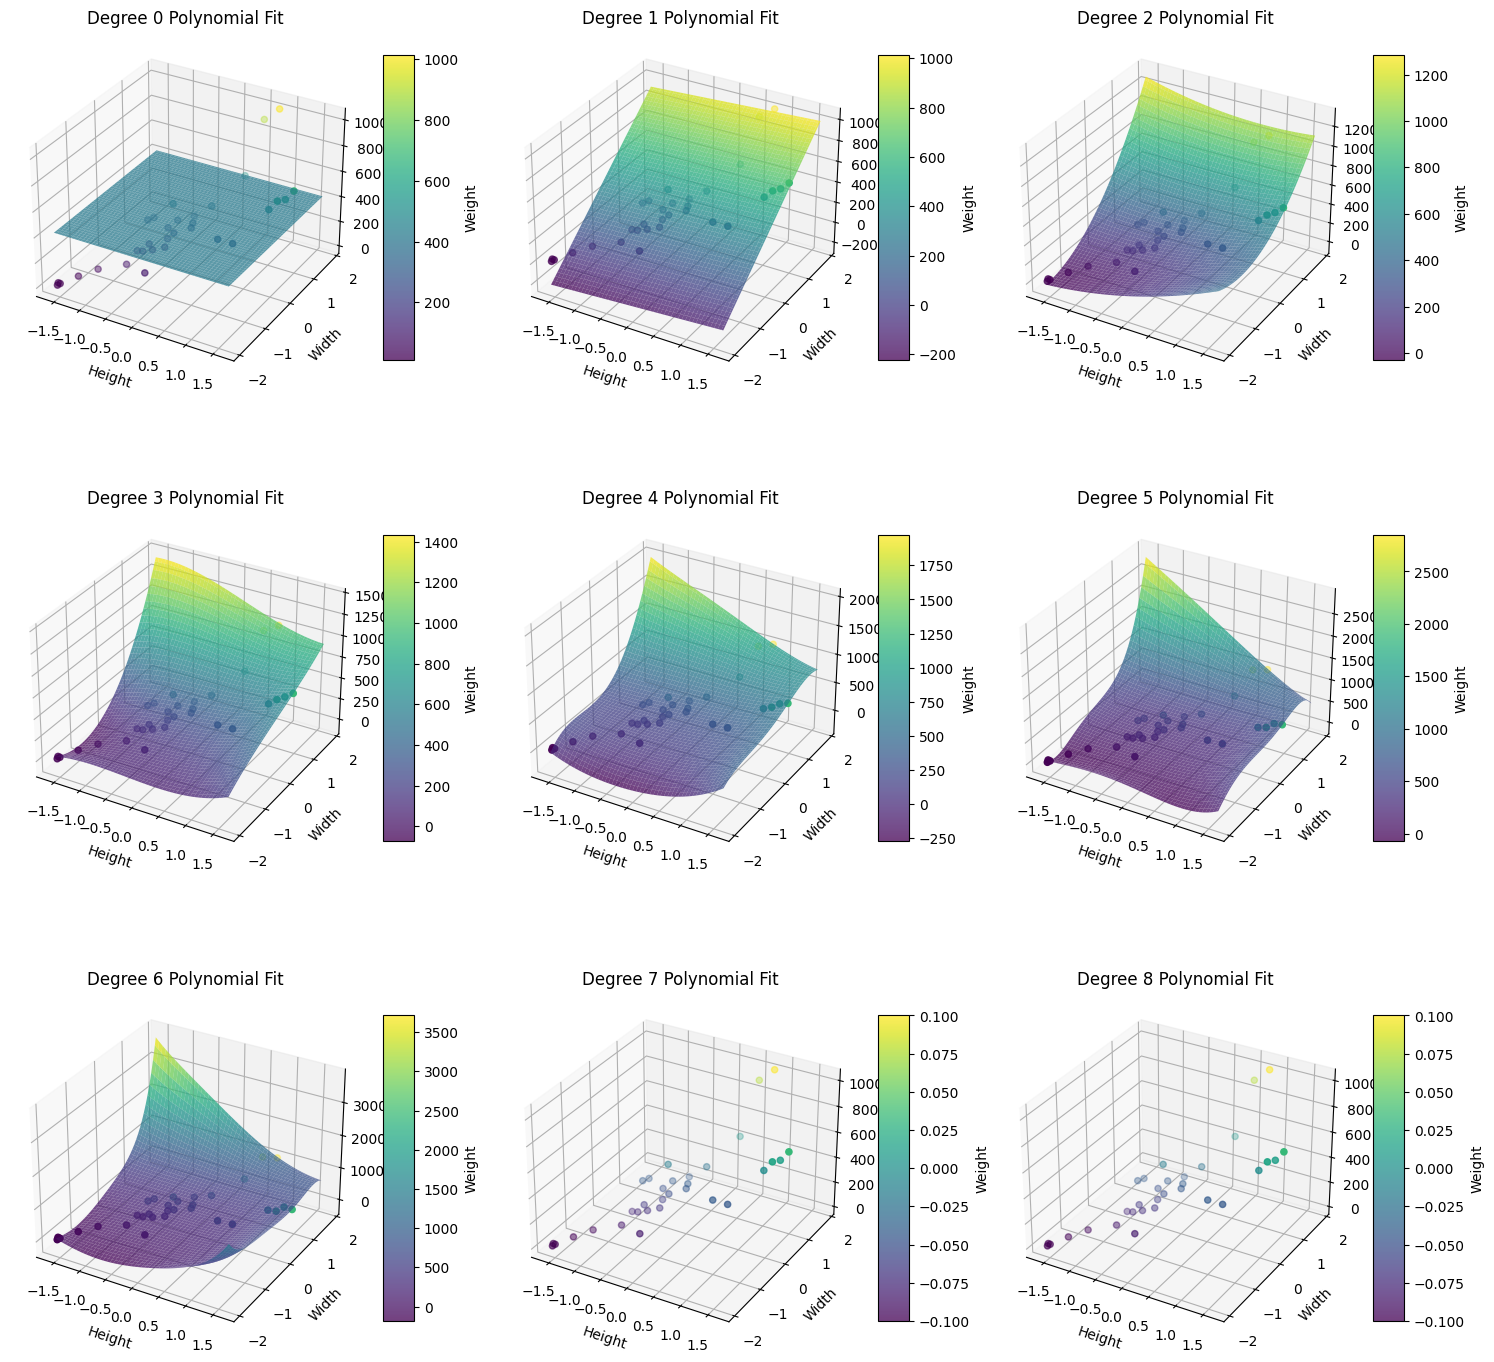

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axes = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})

for degree, ax in zip(range(0, MAX_DEGREE + 1), axes.flatten()):
    weights_matrix = weights[degree]

    height_values = np.linspace(min(test_data['Height']), max(test_data['Height']), 100)
    width_values = np.linspace(min(test_data['Width']), max(test_data['Width']), 100)
    Width, Height = np.meshgrid(width_values, height_values)

    poly_matrix = np.zeros((len(Height.flatten()), weights_matrix.shape[0]))
    col = 0
    for height_pow in range(0, degree + 1):
        for width_pow in range(0, degree + 1):
            if height_pow + width_pow <= degree:
                poly_matrix[:, col] = np.power(Height.flatten(), height_pow) * np.power(Width.flatten(), width_pow)
                col += 1

    predicted_values = np.dot(poly_matrix, weights_matrix).reshape(Height.shape)

    min_value = min(np.min(predicted_values), np.min(test_data['Weight']))
    max_value = max(np.max(predicted_values), np.max(test_data['Weight']))

    surface = ax.plot_surface(Height, Width, predicted_values, cmap='viridis', norm=Normalize(vmin=min_value, vmax=max_value), alpha=0.75)
    scatter = ax.scatter(test_data['Height'], test_data['Width'], test_data['Weight'], c=test_data['Weight'], cmap='viridis')

    ax.set_xlabel('Height')
    ax.set_ylabel('Width')
    ax.set_zlabel('Weight')
    cbar = fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label('Weight')

    ax.set_title(f'Degree {degree} Polynomial Fit')

plt.tight_layout()
plt.show()

#### Best Degree

In [309]:
print("Minimum Train MSE: ", min(training_mean_squared_errors), " at degree: ", training_mean_squared_errors.index(min(training_mean_squared_errors)))
print(training_mean_squared_errors)
print("Minimum Test MSE: ", min(testing_mean_squared_errors), " at degree: ", testing_mean_squared_errors.index(min(testing_mean_squared_errors)))
print(testing_mean_squared_errors)
best_degree = testing_mean_squared_errors.index(min(testing_mean_squared_errors))
print('\nBest degree of polynomial is ', best_degree)

Minimum Train MSE:  20857.91329890643  at degree:  4
[141466.88760389146, 29919.531944944923, 23992.84860887471, 22123.249308459188, 20857.91329890643, 21936.630700461705, 22110.03346518755, nan, nan, nan]
Minimum Test MSE:  7066.970548203115  at degree:  2
[74066.9593636618, 16992.65460075524, 7066.970548203115, 7123.000649344073, 8346.315035762529, 9529.219744574628, 9701.170664823505, nan, nan, nan]

Best degree of polynomial is  2


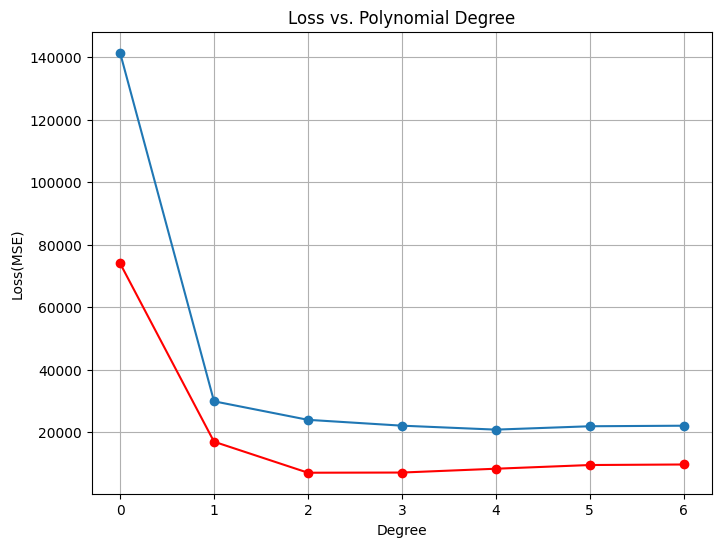

In [310]:
plt.figure(figsize=(8, 6))
plt.plot([i for i in range(10)],training_mean_squared_errors, marker='o', label='Train MSE')
plt.plot([i for i in range(10)],testing_mean_squared_errors, marker='o', color='r', label='Test MSE')
plt.title("Loss vs. Polynomial Degree")
plt.xlabel("Degree")
plt.ylabel("Loss(MSE)")
plt.grid(True)
plt.show()

## Regularized Polynomial Regression

In [311]:
import random

epsilon = 1e-5
q_vals = [0.5,1,2,4]
lambdas_ = np.linspace(0,1,11)
q_vals,lambdas_

def create_pol(X1, X2, degree):
    X_pol = np.column_stack([X1 ** i * X2 ** j for i in range(degree + 1) for j in range(degree + 1) if (i + j) <= degree])
    return X_pol

def init_wt_bias(degree):
    w = np.random.randn(len(create_pol(1, 1, degree)[0])) * 0.01
    b = 0
    return w, b

def eval_model(X, y, w, b):
    predictions = np.dot(X, w) + b
    mse = np.mean((predictions - y) ** 2)
    return mse

def batch_gradient_descent(X, y, w, b, lr, num_iters, lambda_, q):
    for _ in range(num_iters):
        prediction = np.dot(X, w) + b
        gradient_w = (1/len(y)) * np.dot(X.T, (prediction - y)) + 0.5* lambda_ * q * np.power(np.maximum(np.abs(w) ,epsilon), q - 1)* np.sign(w)
        gradient_b = (1/len(y)) * np.sum(prediction - y)
        
        w -= lr * gradient_w
        b -= lr * gradient_b
        
    return w, b

def stochastic_gradient_descent(X, y, w, b, lr, num_iters, lambda_, q):
    N = len(y)
    
    for _ in range(num_iters):
        for i in range(N):
            random_idx = random.randint(0, N - 1)
            xi = X[random_idx]
            yi = y[random_idx]
            
            prediction = np.dot(xi, w) + b
            
            gradient_w = (1/N) * np.dot(xi, (prediction - yi)) + 0.5 * lambda_ * q * np.power(np.abs(w) + epsilon, q - 1)* np.sign(w)
            gradient_b = (1/N) * np.sum(prediction - yi)
            
            w -= lr * gradient_w
            b -= lr * gradient_b
        
    return w, b

In [312]:
models = {}

for q in q_vals:
    for lambda_ in lambdas_:
        print(f'Experimenting with q = {q}, lambda = {lambda_}')
        
        for degree in [best_degree]:
            X_train_pol = create_pol(train_data['Height'].values, train_data['Width'].values, degree=degree)
            
            w_batch, b_batch = init_wt_bias(degree=degree)
            w_stoc, b_stoc = init_wt_bias(degree=degree)
            
            w_batch, b_batch = batch_gradient_descent(X_train_pol, train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)
            w_stoc, b_stoc = stochastic_gradient_descent(X_train_pol,  train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)
            
            X_test_pol = create_pol(test_data['Height'].values, test_data['Width'].values, degree=degree)
            test_error_batch = eval_model(X_test_pol,test_data['Weight'].values, w_batch, b_batch)
            test_error_stoc = eval_model(X_test_pol, test_data['Weight'].values, w_stoc, b_stoc)
            
            models[(q, lambda_, 'B')] = test_error_batch
            models[(q, lambda_, 'S')] = test_error_stoc

Experimenting with q = 0.5, lambda = 0.0


Experimenting with q = 0.5, lambda = 0.1
Experimenting with q = 0.5, lambda = 0.2
Experimenting with q = 0.5, lambda = 0.30000000000000004
Experimenting with q = 0.5, lambda = 0.4
Experimenting with q = 0.5, lambda = 0.5
Experimenting with q = 0.5, lambda = 0.6000000000000001
Experimenting with q = 0.5, lambda = 0.7000000000000001
Experimenting with q = 0.5, lambda = 0.8
Experimenting with q = 0.5, lambda = 0.9
Experimenting with q = 0.5, lambda = 1.0
Experimenting with q = 1, lambda = 0.0
Experimenting with q = 1, lambda = 0.1
Experimenting with q = 1, lambda = 0.2
Experimenting with q = 1, lambda = 0.30000000000000004
Experimenting with q = 1, lambda = 0.4
Experimenting with q = 1, lambda = 0.5
Experimenting with q = 1, lambda = 0.6000000000000001
Experimenting with q = 1, lambda = 0.7000000000000001
Experimenting with q = 1, lambda = 0.8
Experimenting with q = 1, lambda = 0.9
Experimenting with q = 1, lambda = 1.0
Experimenting with q = 2, lambda = 0.0
Experimenting with q = 2, lamb

In [313]:
mn = 1e9
best = []

for q in q_vals:
    for lambda_ in lambdas_:
        for t in ['B','S']:
            best.append((q,lambda_,t))

best_sorted = sorted(best, key=lambda x: models[(x[0], x[1], x[2])])
four_least = best_sorted[:4]
print(four_least)
print([models[i] for i in four_least])

[(1, 0.2, 'B'), (1, 0.30000000000000004, 'B'), (1, 0.8, 'S'), (1, 0.9, 'S')]
[4926.8861756845145, 4934.0379531608205, 4973.085947991441, 5097.867176196482]


### Four Optimal Regularized Plots

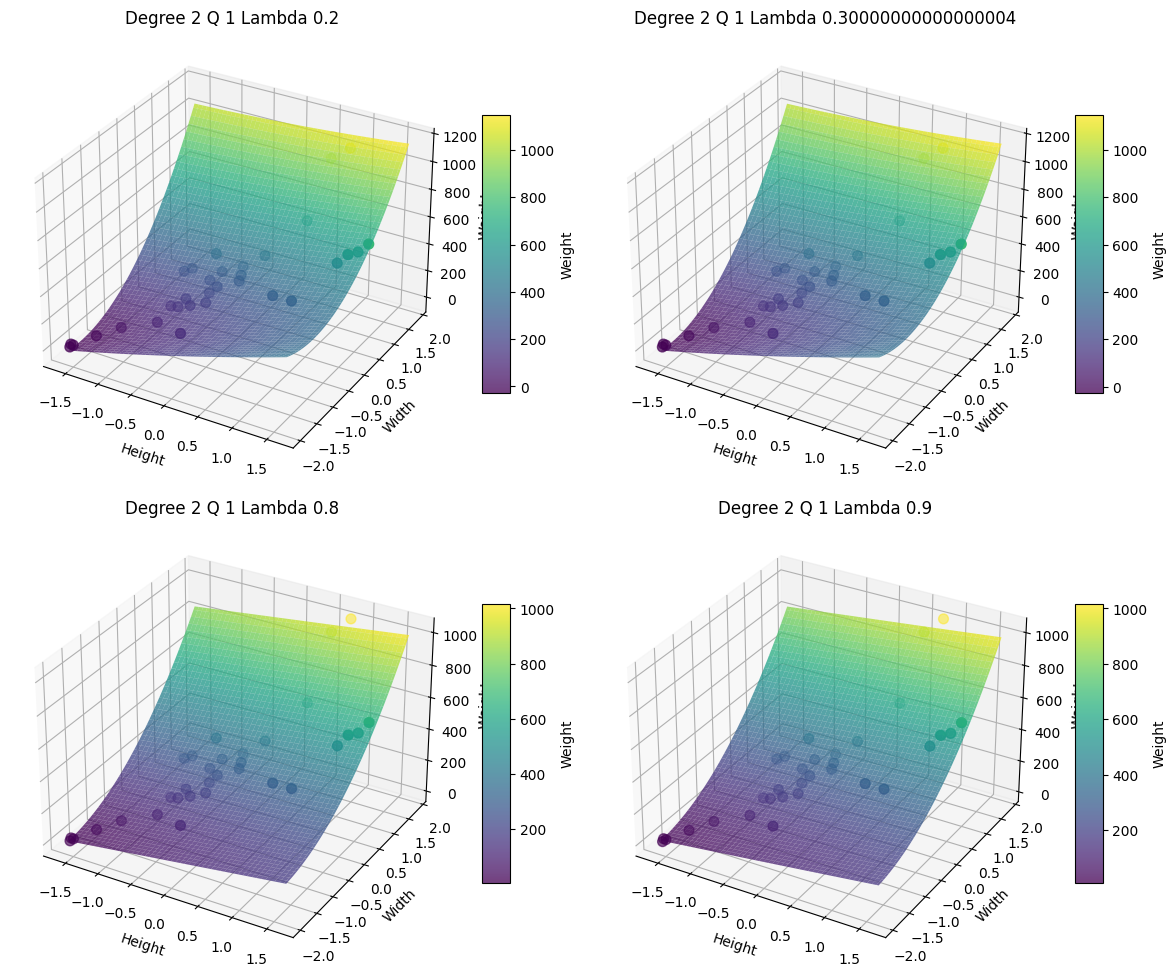

In [316]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})

for (q, lambda_, t), ax in zip(four_least, axes.flatten()):
    degree = best_degree
    X_train_pol = create_pol(train_data['Height'].values, train_data['Width'].values, degree=degree)

    if t == 'B':
        w_batch, b_batch = init_wt_bias(degree=degree)
        w_batch, b_batch = batch_gradient_descent(X_train_pol, train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)
    else:
        w_batch, b_batch = init_wt_bias(degree=degree)
        w_batch, b_batch = stochastic_gradient_descent(X_train_pol, train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)   

    height_values = np.linspace(min(test_data['Height']), max(test_data['Height']), 100)
    width_values = np.linspace(min(test_data['Width']), max(test_data['Width']), 100)
    Width, Height = np.meshgrid(width_values, height_values)

    X_test_pol = create_pol(Height.reshape(-1,), Width.reshape(-1,), degree=degree)
    predicted_values = np.dot(X_test_pol, w_batch) + b_batch
    predicted_values = predicted_values.reshape(Height.shape)

    min_value = min(np.min(predicted_values), np.min(test_data['Weight']))
    max_value = max(np.max(predicted_values), np.max(test_data['Weight']))

    surface = ax.plot_surface(Height, Width, predicted_values, cmap='viridis', norm=Normalize(vmin=min_value, vmax=max_value), alpha=0.75)
    scatter = ax.scatter(test_data['Height'], test_data['Width'], test_data['Weight'], c=test_data['Weight'], cmap='viridis', s=50)

    ax.set_xlabel('Height')
    ax.set_ylabel('Width')
    ax.set_zlabel('Weight')
    cbar = fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label('Weight')
    ax.set_title(f'Degree {degree} Q {q} Lambda {lambda_}')

plt.tight_layout()
plt.show()

### Comparative Analysis b/w Regularized and Non-Regularized

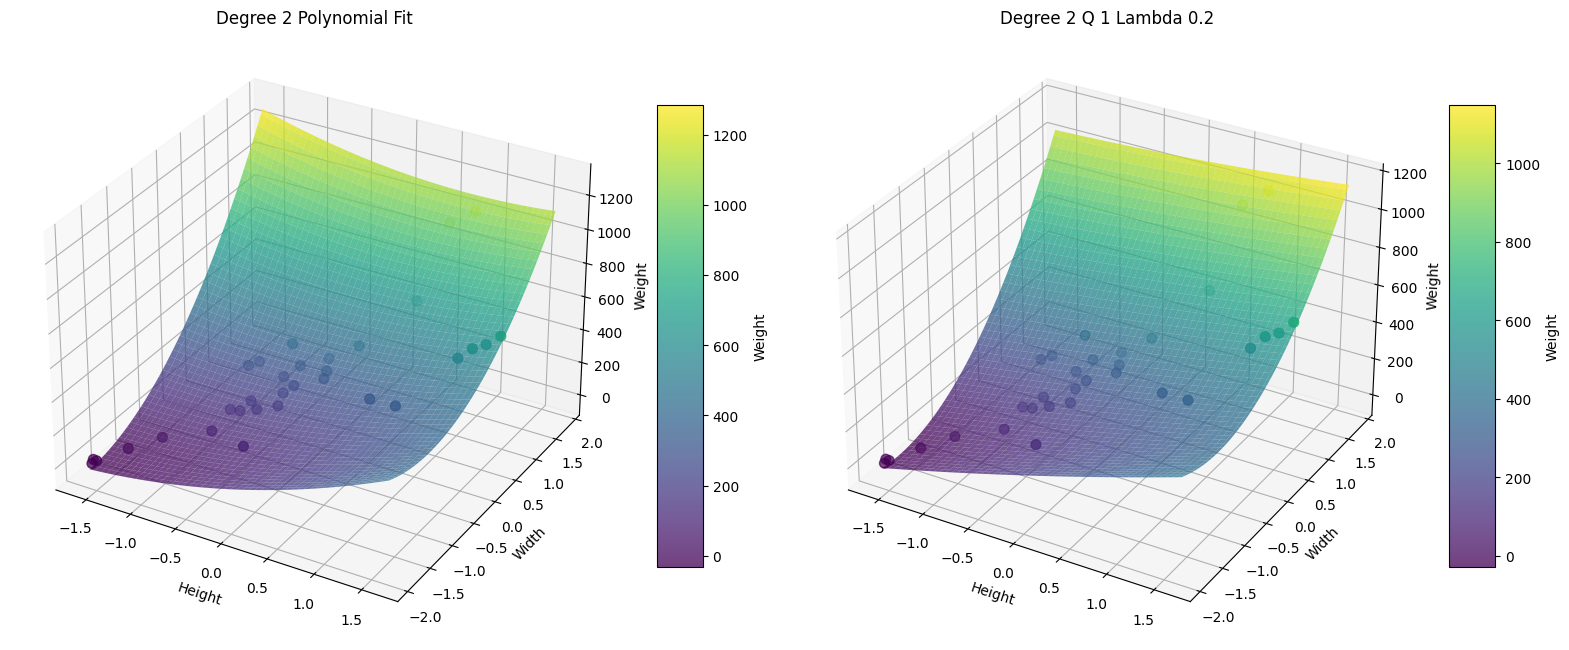

In [322]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})

ax = axes[0]
degree = best_degree
weights_matrix = weights[degree]

height_values = np.linspace(min(test_data['Height']), max(test_data['Height']), 100)
width_values = np.linspace(min(test_data['Width']), max(test_data['Width']), 100)
Width, Height = np.meshgrid(width_values, height_values)

poly_matrix = np.zeros((len(Height.flatten()), weights_matrix.shape[0]))
col = 0
for height_pow in range(0, degree + 1):
    for width_pow in range(0, degree + 1):
        if height_pow + width_pow <= degree:
            poly_matrix[:, col] = np.power(Height.flatten(), height_pow) * np.power(Width.flatten(), width_pow)
            col += 1

predicted_values = np.dot(poly_matrix, weights_matrix).reshape(Height.shape)

min_value = min(np.min(predicted_values), np.min(test_data['Weight']))
max_value = max(np.max(predicted_values), np.max(test_data['Weight']))

surface = ax.plot_surface(Height, Width, predicted_values, cmap='viridis', norm=Normalize(vmin=min_value, vmax=max_value), alpha=0.75)
scatter = ax.scatter(test_data['Height'], test_data['Width'], test_data['Weight'], c=test_data['Weight'], cmap='viridis', s=50)

ax.set_xlabel('Height')
ax.set_ylabel('Width')
ax.set_zlabel('Weight')
cbar = fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Weight')
ax.set_title(f'Degree {degree} Polynomial Fit')

ax = axes[1]
(q, lambda_, t) = four_least[0]

degree = best_degree
X_train_pol = create_pol(train_data['Height'].values, train_data['Width'].values, degree=degree)

if t == 'B':
    w_batch, b_batch = init_wt_bias(degree=degree)
    w_batch, b_batch = batch_gradient_descent(X_train_pol, train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)
else:
    w_batch, b_batch = init_wt_bias(degree=degree)
    w_batch, b_batch = stochastic_gradient_descent(X_train_pol, train_data['Weight'].values, w_batch, b_batch, lr=0.01, num_iters=500, lambda_=lambda_, q=q)   

height_values = np.linspace(min(test_data['Height']), max(test_data['Height']), 100)
width_values = np.linspace(min(test_data['Width']), max(test_data['Width']), 100)
Width, Height = np.meshgrid(width_values, height_values)

X_test_pol = create_pol(Height.reshape(-1,), Width.reshape(-1,), degree=degree)
predicted_values = np.dot(X_test_pol, w_batch) + b_batch
predicted_values = predicted_values.reshape(Height.shape)

min_value = min(np.min(predicted_values), np.min(test_data['Weight']))
max_value = max(np.max(predicted_values), np.max(test_data['Weight']))

surface = ax.plot_surface(Height, Width, predicted_values, cmap='viridis', norm=Normalize(vmin=min_value, vmax=max_value), alpha=0.75)
scatter = ax.scatter(test_data['Height'], test_data['Width'], test_data['Weight'], c=test_data['Weight'], cmap='viridis', s=50)

ax.set_xlabel('Height')
ax.set_ylabel('Width')
ax.set_zlabel('Weight')
cbar = fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Weight')
ax.set_title(f'Degree {degree} Q {q} Lambda {lambda_}')

plt.tight_layout()
plt.show()

In [320]:
print("Best Non-Regularized Model | Test MSE :", min(testing_mean_squared_errors))
print("Best Regularized Model | Test MSE :", models[four_least[0]])

Best Non-Regularized Model | Test MSE : 7066.970548203115
Best Regularized Model | Test MSE : 4926.8861756845145
